In [12]:
import sys
sys.path.append("./../..")

from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle

In [13]:
dt = 1e-6
Sample_frequency = 25_000 
DeltaT = 1/Sample_frequency  
TotalT = 13
transient = 3
EffectiveT = TotalT - transient

sampled_point_amount = np.int64((EffectiveT)/DeltaT) 
t = np.linspace(0., EffectiveT, sampled_point_amount) 

print("Effective simulation time: %d (s)" % EffectiveT)

Effective simulation time: 10 (s)


In [14]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [15]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

As a reference, here's a part of the function we called to compute the summary statistics on cloud. 

```python
def compute_summary_statistics(single_x_trace, single_theta, DeltaT = 1/25e3, TotalT = 10):
    summary_statistics = {}
    t = np.linspace(0., TotalT, single_x_trace.shape[0])
    t_corr = TotalT/20 # Hyperparameter
    
    # Autocorrelation
    Cxx = stat_corr_single(single_x_trace, DeltaT)
    idx_corr = where((t>0)*(t<t_corr))[0]
    cxx = Cxx[idx_corr]
    summary_statistics["Cxx"] = cxx  
    
    # S red
    S_red1, S_red2, S_red = stat_s_redx(Cxx, t_corr, t)
    summary_statistics["s_red1"] = S_red1
    summary_statistics["s_red2"] = S_red2
    summary_statistics["s_redx"] = S_red 
    
    return summary_statistics
```

In [16]:
def stat_corr_single(single_x_trace, DeltaT):
    '''
    Computes the autocorrelation for a single x trace signal.

    INPUT
    singles_x_trace: single x trace signal
    DeltaT: sampling time
    ((t: time array
    t_corr: maximum time for the correlation))

    OUTPUT
    Cxx: autocorrelation x signal
    '''

    sampled_point_amount = single_x_trace.shape[0]
    #idx_corr = where((t>0)*(t<t_corr))[0]
    Cxx= corr(single_x_trace, single_x_trace, sampled_point_amount, dt=DeltaT) # compute the autocorrellation for each x trace

    return Cxx


def stat_s_redx(Cxx, t_corr, t, mu_x=2.8e4, k_x=6e-3, kbT=3.8):
    '''
    Computes the reduced energy production for a single x trace signal.

    INPUT
    Cxx: autocorrelation signal
    t_corr: maximum time for the correlation
    t: time array
    theta_i: parameters

    OUTPUT
    S_red: reduced x energy production
    '''
    D_x = kbT * mu_x
    
    S1 = cumulative_trapezoid(Cxx, x=t, axis=-1, initial=0)
    S1 = cumulative_trapezoid(S1, x=t, axis=-1, initial=0)
    idx_corr = where((t>0)*(t<t_corr))[0]
    S_red1 = (Cxx[0]-Cxx[idx_corr])/(D_x*t[idx_corr]) # First term in S_red
    S_red2 = ((mu_x*k_x)**2)*S1[idx_corr]/(D_x*t[idx_corr]) # Second term in S_red
    S_red = S_red1 + S_red2 # Compute S_red

    return S_red1, S_red2, S_red

In [17]:
%%time
n_sim = 10
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 29.3 s, sys: 141 ms, total: 29.4 s
Wall time: 29.3 s


In [18]:
print("X_trace shape: ", x_trace.shape)
print("theta shape: ", theta.shape)

X_trace shape:  (10, 249999)
theta shape:  (5, 10, 1)


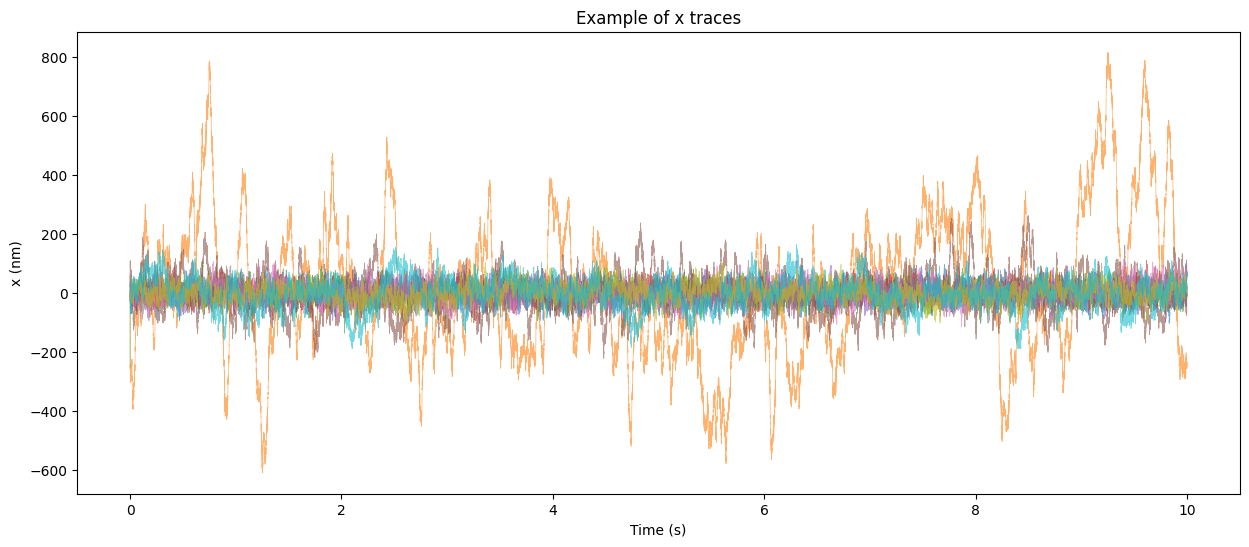

In [19]:
plt.figure(figsize=(15, 6))
plt.title("Example of x traces")
for i in range(n_sim):
    plt.plot(t, x_trace[i], alpha=0.6, lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("x (nm)");

In [21]:
# Hyperparameters of the statistical functions
## Remember that TotalT does include the transient time
## Note that if t_corr > EffectiveT, idx_corr will be the same as t
t_corr = 0.8

# Lists to store the results
Cxx_list = []
s_red1_list = []
s_red2_list = []
s_redx_list = []

# Iterate over the simulations
for i in range(n_sim):
    ## Note that Cxx is cutted after the computation the s_redx
    ## Instead, s_redx is cutted inside stat_ the function
    Cxx = stat_corr_single(x_trace[i], DeltaT)
    idx_corr = where((t>0)*(t<t_corr))[0]
    
    s_red1, s_red2, s_redx = stat_s_redx(Cxx, t_corr, t)
    
    Cxx_list.append(Cxx[idx_corr])
    s_red1_list.append(s_red1)
    s_red2_list.append(s_red2)
    s_redx_list.append(s_redx)

In [22]:
# Define the t_cxx array
t_cxx = t[where((t>0)*(t<t_corr))[0]]
t_cxx[-1]

0.7999663997311979

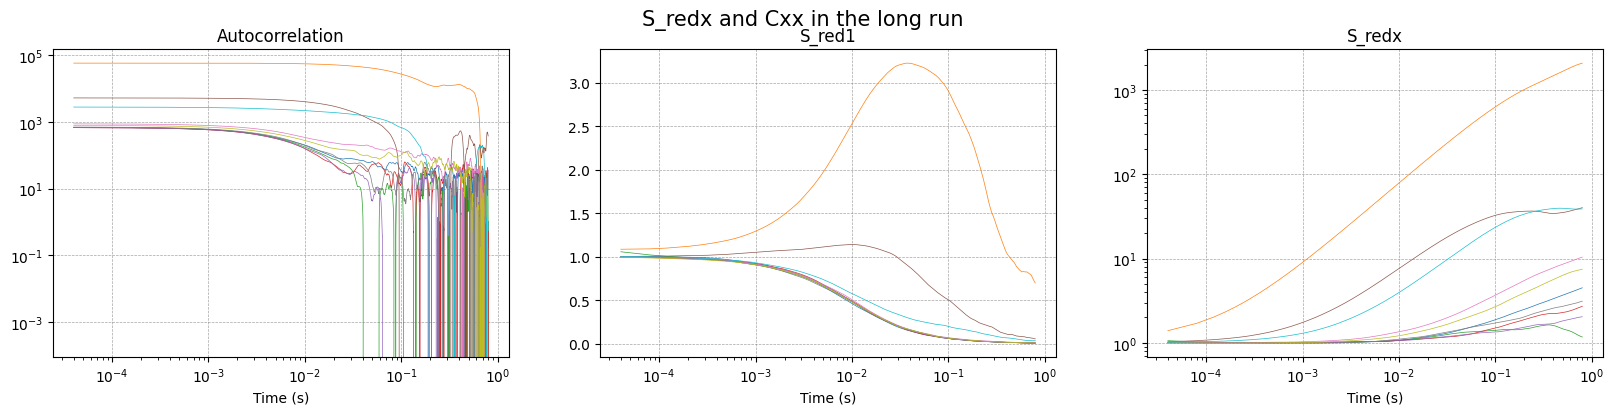

In [24]:
plt.figure(figsize=(20, 4))
plt.suptitle("S_redx and Cxx in the long run", fontsize=15)

plt.subplot(131)
plt.title("Autocorrelation")
for i in range(n_sim):
    plt.plot(t_cxx, Cxx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(132)
plt.title("S_red1")
for i in range(n_sim):
    plt.plot(t_cxx, s_red1_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(133)
plt.title("S_redx")
for i in range(n_sim):
    plt.plot(t_cxx, s_redx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
